In [46]:
from trainer import *
import cv2


with open('configs/test_config.yaml') as file:
    config = yaml.full_load(file)
 
trainer = Trainer(config)


Saving checkpoint..
Initializing samples..


In [47]:
dataset = trainer.dataset
s = dataset.__getitem__(10)

array([0.33553426, 0.01814677, 1.10474336])

array([-0.30135079, -0.0188718 , -0.99963057])

In [48]:
def plt_tensor(img, proj_img=False):
    img = (np.transpose(img.cpu().numpy(), (1, 2, 0)))
    
    print(img.shape)
    
    if not proj_img:
        img = 0.5 + (img * 0.5)
    return img

# Create a sample

In [49]:
batch    = next(iter(trainer.train_loader))

In [50]:
tgt        = batch['tgt']
ref_imgs   = batch['ref_imgs']
intrinsics = batch['intrinsics']
poses      = batch['oxts']
depth      = batch['groundtruth']
batch_option  = 0
pose_option   = 0

(384, 1280, 3)
(384, 1280, 3)
(384, 1280, 3)


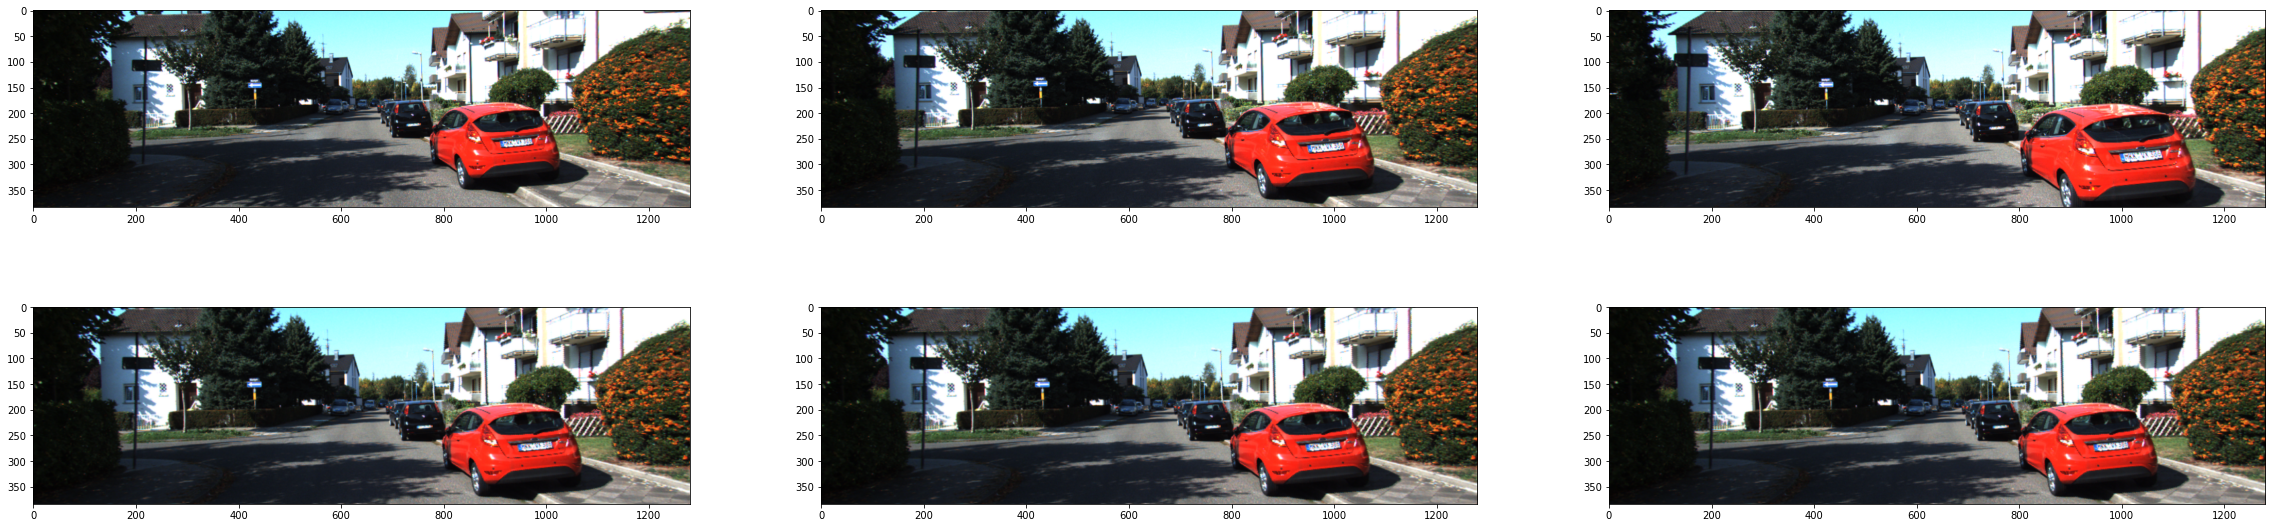

In [53]:
warped_sample = cv2.cvtColor(cv2.imread('./images/warping/33.png'), cv2.COLOR_RGB2BGR)

tgt_img = tgt[batch_option]
ref_img = ref_imgs[pose_option][batch_option]
K = intrinsics[batch_option]

fig, axs = plt.subplots(2, 3, figsize=(40, 10)) 
axs[0, 0].imshow(plt_tensor(ref_imgs[0][1]))
axs[0, 1].imshow(plt_tensor(tgt[1]))
axs[0, 2].imshow(plt_tensor(ref_imgs[1][1]))
axs[1, 0].imshow(warped_sample)
axs[1, 1].imshow(warped_sample)
axs[1, 2].imshow(warped_sample)

In [7]:
from geometry.transform import  Transform
from geometry.pose_geometry import *

T = Transform()

W = tgt.shape[3]
H = tgt.shape[2]

grid = T.image_grid(1, tgt.shape[2], tgt.shape[3], tgt.dtype, tgt.device)
flat_grid = grid.view(1, 3, -1)  # [B,3,HW]

In [8]:
# convert to cam coords
xnorm = K.inverse().float() @ flat_grid.float()
xnorm = xnorm.view(1, 3, H, W)

In [9]:
# transform to different frame
flat_cam_coords = xnorm.view(1, 3, -1)

rot = torch.eye(3)
t   = poses[0][0][3:].unsqueeze(1)


Xc = rot.float() @ flat_cam_coords.float()
Xc = Xc + t/t[2].float()
Xc = K.float() @ Xc.float()
Xc

# T = K @ pose_vec2mat(poses[0][0].unsqueeze(0)).double()
# rot, tr = T[..., :3], T[..., -1:]
# Xc = rot.float() @ flat_cam_coords.float()
# Xc = Xc + (tr/tr[:, 2]).float()
# Xc

tensor([[[ 612.3750,  613.3750,  614.3750,  ..., 1889.3750, 1890.3750,
          1891.3750],
         [ 177.7044,  177.7044,  177.7044,  ...,  560.7044,  560.7044,
           560.7044],
         [   2.0000,    2.0000,    2.0000,  ...,    2.0000,    2.0000,
             2.0000]]])

In [10]:
# Normalize points
X = Xc[:, 0]
Y = Xc[:, 1]
Z = Xc[:, 2].clamp(min=1e-5)
Xnorm = 2 * (X / Z) / (W - 1) - 1.
Ynorm = 2 * (Y / Z) / (H - 1) - 1.

# Return pixel coordinates
X_grid = torch.stack([Xnorm, Ynorm], dim=-1).view(1, H, W, 2).float()
X_grid

tensor([[[[-0.5212, -0.5360],
          [-0.5204, -0.5360],
          [-0.5196, -0.5360],
          ...,
          [ 0.4772, -0.5360],
          [ 0.4780, -0.5360],
          [ 0.4788, -0.5360]],

         [[-0.5212, -0.5334],
          [-0.5204, -0.5334],
          [-0.5196, -0.5334],
          ...,
          [ 0.4772, -0.5334],
          [ 0.4780, -0.5334],
          [ 0.4788, -0.5334]],

         [[-0.5212, -0.5308],
          [-0.5204, -0.5308],
          [-0.5196, -0.5308],
          ...,
          [ 0.4772, -0.5308],
          [ 0.4780, -0.5308],
          [ 0.4788, -0.5308]],

         ...,

         [[-0.5212,  0.4588],
          [-0.5204,  0.4588],
          [-0.5196,  0.4588],
          ...,
          [ 0.4772,  0.4588],
          [ 0.4780,  0.4588],
          [ 0.4788,  0.4588]],

         [[-0.5212,  0.4614],
          [-0.5204,  0.4614],
          [-0.5196,  0.4614],
          ...,
          [ 0.4772,  0.4614],
          [ 0.4780,  0.4614],
          [ 0.4788,  0.4614]],



In [11]:
proj = F.grid_sample(ref_img.unsqueeze(0).float(), X_grid, mode='bilinear', padding_mode='zeros', align_corners=True)

(384, 1280, 3)
(384, 1280, 3)
(384, 1280, 3)


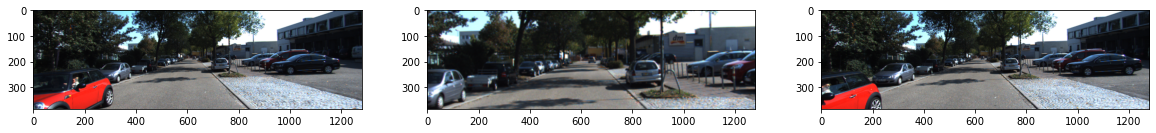

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20)) 
axs[0].imshow(plt_tensor(ref_imgs[0][0]))
axs[1].imshow(plt_tensor(proj[0]))
axs[2].imshow(plt_tensor(tgt[0]))

In [13]:
from geometry.warp import inverse_warp

img, _ = inverse_warp(ref_imgs[0].double(), depth.double(), poses[0].double(), intrinsics.double(), rotation_mode='euler', padding_mode='zeros')

(384, 1280, 3)
(384, 1280, 3)
(384, 1280, 3)


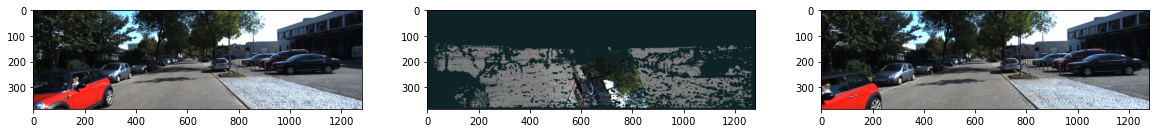

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20)) 
axs[0].imshow(plt_tensor(ref_imgs[0][0]))
axs[1].imshow(plt_tensor(img[0]))
axs[2].imshow(plt_tensor(tgt[0]))

# Inference

Saving checkpoint..
Initializing samples..


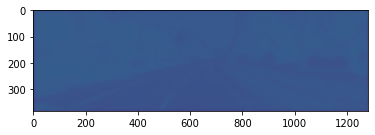

In [1]:
from os import sep
from trainer import *

from utils.transforms import UnNormalize
from geometry.pose_geometry import *

# load checkpoint
save_path = './pretrained/generic_sfm.pth'
checkpoint = torch.load(save_path)
depth_model_state_dict = checkpoint['dpth_mdl_state_dict']
pose_model_state_dict  = checkpoint['pose_mdl_state_dict']

# init dataset
with open('configs/test_config.yaml') as file:
    config = yaml.full_load(file)

trainer    = Trainer(config)
dataloader = trainer.train_loader

In [41]:
one_sample = trainer.dataset.__getitem__(100)


# load a depth model
depth_model = trainer.depth_model
depth_model.load_state_dict(depth_model_state_dict)
depth_model.eval()

# load a pose model
pose_model = trainer.pose_model
pose_model.load_state_dict(pose_model_state_dict)
pose_model.eval()

# test input image
input_imgs = one_sample['tgt'].unsqueeze(0).to(trainer.device)
ref_imgs   = [img.unsqueeze(0).to(trainer.device) for img in one_sample['ref_imgs']]

with torch.no_grad():
    # test and plot
    depth = depth_model(input_imgs)
    pose  = pose_model(input_imgs, ref_imgs)

# figure out all outputs
img        = (1/depth[0][0].squeeze()).cpu().detach().numpy()



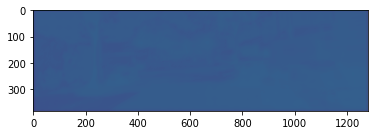

In [42]:
depth = img / np.max(img)
plt.imshow(depth)

In [43]:
pose

tensor([[[ 0.0417, -0.0699,  0.0162,  0.0016,  0.0005,  0.0162],
         [ 0.0158,  0.0163, -0.0053,  0.0024,  0.0232, -0.0087]]],
       device='cuda:0')